In [1]:
import numpy as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def oscillator(d, w0, x):
    assert d < w0 ## it checks if d < w0
    w = torch.sqrt(w0**2-d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y


Generate datapoints to train

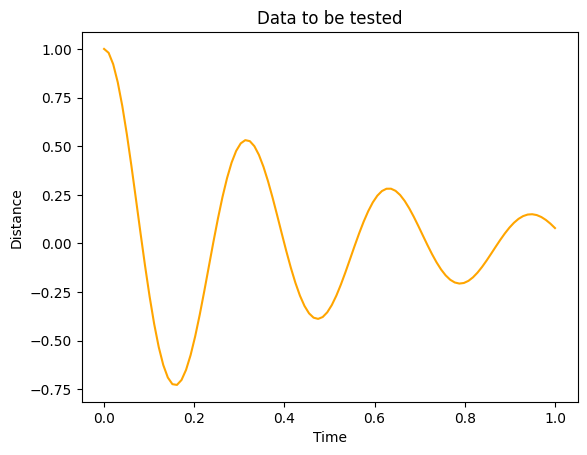

In [37]:
x_test=torch.linspace(0,1,100).view(-1,1)
d=torch.tensor([[2.0]]).reshape(1,1)
w0=torch.tensor([[20.0]]).reshape(1,1)
output=oscillator(d,w0,x_test)
# print(output)
x_data=x_test[0]
y_data=output[0]
plt.figure()
plt.plot(x_test,output,color="orange",label="Sliced data")
plt.title("Data to be tested")
plt.xlabel("Time")
plt.ylabel("Distance")
plt.show()

We define three losses
1.   Due to initial condition
*   u(t=0)=1
*   du/dt(t=0)=0
2.   Due to physics loss
*   d2y_dt2+mu*dy_dt+k*y=0






In [14]:
class FCN(nn.Module):

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

0 tensor(1.1866, grad_fn=<AddBackward0>)
1000 tensor(0.2719, grad_fn=<AddBackward0>)
2000 tensor(0.0993, grad_fn=<AddBackward0>)
3000 tensor(0.0947, grad_fn=<AddBackward0>)
4000 tensor(0.0744, grad_fn=<AddBackward0>)
5000 tensor(0.0487, grad_fn=<AddBackward0>)
6000 tensor(0.0395, grad_fn=<AddBackward0>)
7000 tensor(0.0355, grad_fn=<AddBackward0>)
8000 tensor(0.0318, grad_fn=<AddBackward0>)
9000 tensor(0.0270, grad_fn=<AddBackward0>)
10000 tensor(0.0229, grad_fn=<AddBackward0>)
11000 tensor(0.0180, grad_fn=<AddBackward0>)
12000 tensor(0.0114, grad_fn=<AddBackward0>)
13000 tensor(0.0055, grad_fn=<AddBackward0>)
14000 tensor(0.0064, grad_fn=<AddBackward0>)
15000 tensor(0.0011, grad_fn=<AddBackward0>)
16000 tensor(0.0008, grad_fn=<AddBackward0>)
17000 tensor(0.0014, grad_fn=<AddBackward0>)
18000 tensor(0.0009, grad_fn=<AddBackward0>)
19000 tensor(0.0006, grad_fn=<AddBackward0>)


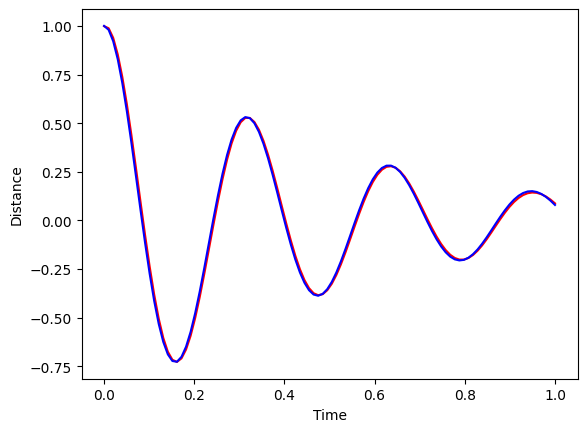

In [40]:
torch.manual_seed(123)
x_physics=torch.linspace(0,1,50,requires_grad=True).reshape(-1,1)
pinn=FCN(1,1,32,3)
mu, k = 2*d, w0**2
optimizer=torch.optim.Adam(pinn.parameters(),lr=1e-3)
lmbda1=1e-1
lmbda2=3e-4
loss1f=[]
x0=torch.tensor([[0.]],requires_grad=True).reshape(1,1)
for i in range(20000):
    optimizer.zero_grad()
    # data loss of 2 points
    y_h=pinn.forward(x_data)
    loss1=torch.mean((y_h-y_data)**2)

    yt=pinn.forward(x0)
    dy_dt1=torch.autograd.grad(yt,x0,torch.ones_like(yt),create_graph=True)[0]
    loss2=torch.mean((yt-dy_dt1)**2)


    # physics loss
    yp=pinn.forward(x_physics)
    dy_dt=torch.autograd.grad(yp,x_physics,torch.ones_like(yp),create_graph=True)[0]
    d2y_dt2=torch.autograd.grad(dy_dt,x_physics,torch.ones_like(dy_dt),create_graph=True)[0]

    loss3=torch.mean((d2y_dt2+mu*dy_dt+k*yp)**2)

    # energy loss
    # w0**2/2 is initial energy

    # loss3=torch.mean((((dy_dt)**2)*0.5 +(w0**2)*(yp**2)*0.5-(w0**2)*0.5)**2)

    loss=loss1+lmbda1*loss2+lmbda2*loss3
    loss1f.append(loss.detach())


    loss.backward()
    optimizer.step()
    if(i%1000==0):
      print(i,loss)


with torch.no_grad():
  yy=pinn.forward(x_test)
  plt.figure()

  plt.plot(x_test,yy,color="red")
  plt.plot(x_test,output,color="blue")
  plt.xlabel("Time")
  plt.ylabel("Distance")

  plt.show()






Text(0, 0.5, 'Loss')

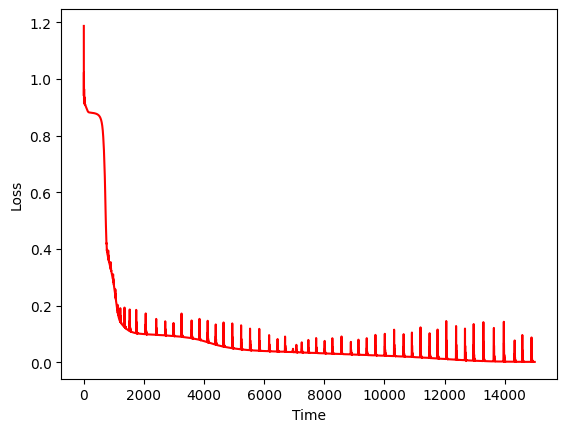

In [39]:
plt.figure()

plt.plot(loss1f,color="red")
plt.xlabel("Time")
plt.ylabel("Loss")